# Plusieurs modèles, données disjointes

On cherche à prédire la note d'un vin mais on suppose que cette qualité est dépendante de la couleur et qu'il faudrait appliquer des modèles différents selon la couleur.

In [2]:
%matplotlib inline

## données

In [1]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()

In [3]:
X = df.drop(["quality", "color"], axis=1)
y = df["quality"]
color = df["color"]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, color_train, color_test = train_test_split(
    X, y, color
)

## version manuelle

On cale d'abord un modèle linéaire sur toute la base.

In [5]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(X_train, y_train)

/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, clr.predict(X_test))

0.4793846153846154

Et maintenant on essaye de caler un modèle différent selon les couleurs.

In [7]:
X_train_white = X_train[color_train == "white"]
y_train_white = y_train[color_train == "white"]
X_train_red = X_train[color_train == "red"]
y_train_red = y_train[color_train == "red"]

In [8]:
clr_white = LogisticRegression()
clr_white.fit(X_train, y_train)
clr_red = LogisticRegression()
clr_red.fit(X_train_red, y_train_red)

/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

LogisticRegression()

In [9]:
X_test_white = X_test[color_test == "white"]
y_test_white = y_test[color_test == "white"]
X_test_red = X_test[color_test == "red"]
y_test_red = y_test[color_test == "red"]

In [10]:
acc_white = accuracy_score(y_test_white, clr_white.predict(X_test_white))
acc_red = accuracy_score(y_test_red, clr_red.predict(X_test_red))
acc_white, acc_red

(0.47843775427176566, 0.5984848484848485)

Il faut agréger pour obtenir les performances sur la base complète.

In [11]:
acc2 = (acc_white * len(y_test_white) + acc_red * len(y_test_red)) / len(y_test)
acc2

0.5076923076923077

C'est un petit peu mieux mais l'ensemble est compliqué à mettre en place. Il serait plus simple d'automatiser pour pouvoir faire de la validation croisée.

## Automatisation

Au début, j'avais pensé écrire une classe inspirée de l'API de [scikit-learn](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/02_basic_of_machine_learning_with_scikit-learn.html#a-recap-on-scikit-learn-s-estimator-interface) qui apprend plusieurs modèles selon une catégorie indiquée lors de l'apprentissage et de la prédiction.

In [15]:
class SkLearnerCategory:
    def fit(X, y, cat):
        # ...
        pass

    def predict(X, cat):
        # ...
        pass

Mais à moins de changer l'interface des [pipeline](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py#L290), il n'y aucun chance pour que cette classe puisse en faire partie. J'ai donc opté pour le design suivant même s'il ne me plaît que moyennement parce qu'il faut gérer plusieurs containers différents (numpy, pandas, ...)

In [16]:
class SkLearnerCategory:
    def __init__(cat="column"):
        self.cat_col = cat
        pass

    def fit(X, y, cat):
        X = X.drop(self.cat_col, axis=1)
        # ...

    def predict(X, cat):
        X = X.drop(self.cat_col, axis=1)
        # ...

Bref, ça marche...

In [22]:
import numpy
import pandas
from sklearn.base import BaseEstimator, ClassifierMixin, clone


class SkLearnerCategory(BaseEstimator, ClassifierMixin):
    def __init__(self, colnameind=None, model=None):
        assert isinstance(
            colnameind, (int, str)
        ), f"colnameind must be str or int not {type(colnameind)}"
        assert model is not None, "model must not be None"
        self.model = model
        self.colnameind = colnameind

    def _get_cat(self, X):
        """
        Retourne les catégories indiquées par *colnameind*.
        """
        if isinstance(self.colnameind, str):
            assert hasattr(
                X, "columns"
            ), "colnameind='{0}' and X is not a DataFrame but {1}".format(
                self.colnameind, type(X)
            )
            return X[self.colnameind]
        return X[:, self.colnameind]

    def _filter_cat(self, c, X, y=None, sample_weight=None):
        """
        Retoure *X*, *y*, *sample_weight* pour la categorie *c* uniquement.
        """
        indices = numpy.arange(0, X.shape[0])
        if isinstance(self.colnameind, str):
            assert hasattr(
                X, "columns"
            ), "colnameind='{0}' and X is not a DataFrame but {1}".format(
                self.colnameind, type(X)
            )
            ind = X[self.colnameind] == c
            sa = None if sample_weight is None else sample_weight[ind]
            y = None if y is None else y[ind]
            ind, x = indices[ind], X.drop(self.colnameind, axis=1)[ind]
        elif hasattr(X, "iloc"):
            ind = X[self.colnameind] == c
            sa = None if sample_weight is None else sample_weight[ind]
            y = None if y is None else y[ind]
            ind, x = indices[ind], X.iloc[ind, -self.colnameind]
        else:
            ind = X[self.colnameind] == c
            sa = None if sample_weight is None else sample_weight[ind]
            y = None if y is None else y[ind]
            ind, x = indices[ind], X[ind, -self.colnameind]
        assert y is None or x.shape[0] == y.shape[0], (
            "Input arrays have different shapes for value='{0}': {1} != {2} "
            "(expected: {3}) type(X)={4}".format(
                c, X.shape[0], y.shape[0], ind.shape, type(X)
            )
        )
        assert sa is None or x.shape[0] == sa.shape[0], (
            "Input arrays have different shapes for value='{0}': {1} != {2} "
            "(expected: {3}) type(X)={4}".format(
                c, X.shape[0], sa.shape[0], ind.shape, type(X)
            )
        )
        return ind, x, y, sa

    ###################
    # API scikit-learn
    ###################

    def fit(self, X, y=None, sample_weight=None, **kwargs):
        cats = set(self._get_cat(X))
        for c in cats:
            if not isinstance(c, str) and numpy.isnan(c):
                raise ValueError(  # pragma: no cover
                    "One of the row has a missing category."
                )

        res = {}
        for c in sorted(cats):
            _, xcat, ycat, scat = self._filter_cat(c, X, y, sample_weight)
            mod = clone(self.model)
            if scat is not None:
                kwargs["sample_weight"] = scat
            mod.fit(xcat, ycat, **kwargs)
            res[c] = mod
        self.models = res
        return self

    def _any_predict(self, X, fct, *args):
        """
        Prédit en appelant le modèle associé à chaque catégorie.
        """
        cats = set(self._get_cat(X))
        for c in cats:
            if not isinstance(c, str) and numpy.isnan(c):
                raise NotImplementedError(  # pragma: no cover
                    "No default value is implemented in case of missing value."
                )

        res = []
        for c in sorted(cats):
            ind, xcat, ycat, _ = self._filter_cat(c, X, *args)
            mod = self.models[c]
            meth = getattr(mod, fct)
            if ycat is None:
                pred = meth(xcat)
            else:
                pred = meth(xcat, ycat)
            if len(pred.shape) == 1:
                pred = pred[:, numpy.newaxis]
            if len(ind.shape) == 1:
                ind = ind[:, numpy.newaxis]
            pred = numpy.hstack([pred, ind])
            res.append(pred)
        try:
            final = numpy.vstack(res)
        except ValueError:  # pragma: no cover
            # Only one dimension.
            final = numpy.hstack(res)
        df = pandas.DataFrame(final)
        df = df.sort_values(df.columns[-1]).reset_index(
            drop=True
        )  # pylint: disable=E1136
        df = df.iloc[:, :-1].values
        if len(df.shape) == 2 and df.shape[1] == 1:
            df = df.ravel()
        return df

    def predict(self, X):
        """
        Prédit en appelant le modèle associé à chaque catégorie.
        La fonction n'est pas parallélisée mais elle le pourrait.
        """
        return self._any_predict(X, "predict")

    def decision_function(self, X):
        """
        Output of the model in case of a regressor, matrix with a score for each class and each sample
        for a classifier
        """
        if hasattr(self.model, "decision_function"):
            return self._any_predict(X, "decision_function")
        raise NotImplementedError(f"No decision_function for {self.model}")

    def predict_proba(self, X):
        """
        Output of the model in case of a regressor, matrix with a score for each class and each sample
        for a classifier
        """
        if hasattr(self.model, "predict_proba"):
            return self._any_predict(X, "predict_proba")
        raise NotImplementedError(  # pragma: no cover
            f"No method predict_proba for {self.model}"
        )

    def score(self, X, y=None, sample_weight=None):
        """
        Returns the mean accuracy on the given test data and labels.
        """
        if self._estimator_type == "classifier":
            from sklearn.metrics import accuracy_score

            return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
        if self._estimator_type == "regressor":
            from sklearn.metrics import r2_score

            return r2_score(y, self.predict(X), sample_weight=sample_weight)
        raise RuntimeError(  # pragma: no cover
            "Unexpected estimator type '{0}', cannot guess default scoring metric.".format(
                self._estimator_type
            )
        )


model = SkLearnerCategory("color", LogisticRegression())
new_x_train = pandas.concat([X_train, color_train], axis=1)
model.fit(new_x_train, y_train)

/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

SkLearnerCategory(colnameind='color', model=LogisticRegression())

In [23]:
new_x_test = pandas.concat([X_test, color_test], axis=1)
accuracy_score(y_test, model.predict(new_x_test))

0.5058461538461538

## Exemple sur un jeu articificiel

Comme ce n'est pas très probant... Essayons de vérifier que l'implémentation est correcte en fabriquant un jeu de données où cela doit marcher.

In [24]:
import numpy

n = 20
colorart = numpy.array([0 for i in range(0, n)] + [1 for i in range(0, n)])
Xart = numpy.random.random(n * 2)
Xart = Xart[:, numpy.newaxis]
Yart = Xart.ravel() + colorart + numpy.random.random(n * 2) / 10

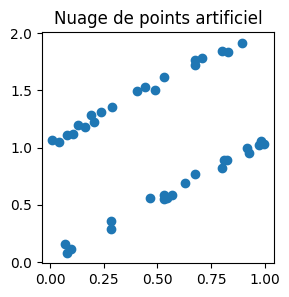

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(Xart, Yart, "o")
ax.set_title("Nuage de points artificiel");

On apprend une régression linéaire.

In [26]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(Xart, Yart)
pred = reg.predict(Xart)

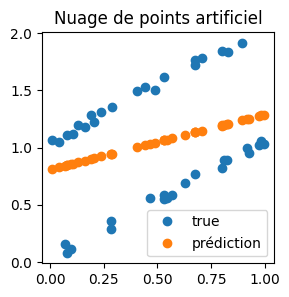

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(Xart, Yart, "o", label="true")
ax.plot(Xart, pred, "o", label="prédiction")
ax.set_title("Nuage de points artificiel")
ax.legend();

Le jeu a été construit pour échouer. Voyons avec les couleurs.

In [28]:
new_x_art = pandas.DataFrame(dict(X=Xart.ravel(), color=colorart))

In [30]:
model = SkLearnerCategory("color", LinearRegression())
model.fit(new_x_art, Yart)
pred2 = model.predict(new_x_art)

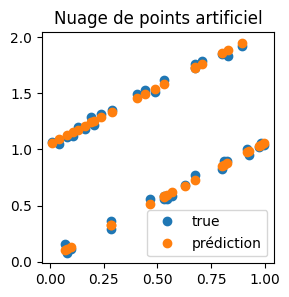

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(Xart, Yart, "o", label="true")
ax.plot(Xart, pred2, "o", label="prédiction")
ax.set_title("Nuage de points artificiel")
ax.legend();

L'implémentation fonctionne. Donc cela n'ajoute rien de caler un modèle différent sur vins rouges et blancs s'il est linéaire. Essaysons avec un autre.

In [33]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test))

model = SkLearnerCategory("color", DecisionTreeClassifier())
model.fit(new_x_train, y_train)
acc2 = accuracy_score(y_test, model.predict(new_x_test))

acc1, acc2

(0.6098461538461538, 0.5981538461538461)

C'est légèrement mieux mais cela varie dès qu'on exécute plusieurs fois. A vérifier avec une validation croisée.

In [34]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
acc1 = accuracy_score(y_test, model.predict(X_test))

model = SkLearnerCategory("color", RandomForestClassifier())
model.fit(new_x_train, y_train)
acc2 = accuracy_score(y_test, model.predict(new_x_test))

acc1, acc2

(0.7003076923076923, 0.7046153846153846)

Ici cela n'apporte rien du tout.

In [35]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

# generate some data to play with
X, y = make_classification(n_informative=5, n_redundant=0, random_state=42)
# ANOVA SVM-C
anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel="linear")
anova_svm = Pipeline([("anova", anova_filter), ("svc", clf)])
anova_svm.fit(X, y)

Pipeline(steps=[('anova',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x7f1ce528ec20>)),
                ('svc', SVC(kernel='linear'))])